In [1]:
import jax
import chex
import einops
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import jax.numpy as jnp
import matplotlib.pyplot as plt

from io import StringIO
from typing import Callable
from functools import partial
from datetime import datetime

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["font.size"] = 16
sns.set_palette("hls", 6)

In [4]:
theta_values = -2, -1, 0, 3, 7,

## HMM Orstein-Uhlenbeck process

$$
    x_{t+\Delta}^\ell = \kappa(\theta_{t, \ell} - x_{t, \ell}) \Delta + \sigma\sqrt{\Delta} W_t
$$

with $W_t \sim \cal{N}(0, 1)$

In [5]:
transition_matrix = jnp.array([
    [0.00,  0.05, 0.05, 0.05, 0.05],
    [0.10,  00.0, 0.10, 0.05, 0.05],
    [0.10,  0.20, 0.00, 0.05, 0.05],
    [0.10,  0.20, 0.01, 0.00, 0.05],
    [0.10,  0.20, 0.20, 0.20, 0.00],
])

p_stay = 1 - transition_matrix.sum(axis=1)
transition_matrix = transition_matrix.at[jnp.diag_indices(5)].set(p_stay)

transition_matrix

Array([[0.8       , 0.05      , 0.05      , 0.05      , 0.05      ],
       [0.1       , 0.7       , 0.1       , 0.05      , 0.05      ],
       [0.1       , 0.2       , 0.59999996, 0.05      , 0.05      ],
       [0.1       , 0.2       , 0.01      , 0.64      , 0.05      ],
       [0.1       , 0.2       , 0.2       , 0.2       , 0.3       ]],      dtype=float32)

## Loading datset

In [6]:
date_init = datetime.timestamp(datetime(2000, 1, 1))
date_end = datetime.timestamp(datetime(2023, 12, 8))

config = {
    "events": "history",
    "period1": str(int(date_init)),
    "period2": str(int(date_end)),
    "includeAdjustedClose": "true"
}

In [7]:
assets = ["JPM", "AAPL", "SHEL", "WMT", "KO", "HD"]

In [8]:
datasets = {}
for asset in assets:
    url = f"https://query1.finance.yahoo.com/v7/finance/download/{asset}"
    r = requests.get(
        url,
        headers={'User-agent': 'Mozilla/5.0'},
        params=config
    )

    data = pd.read_csv(StringIO(r.text))
    data["Date"] = pd.to_datetime(data["Date"])
    data = data.set_index("Date")

    series = data["Adj Close"]
    series.name = asset
    datasets[asset] = series
datasets = pd.DataFrame.from_dict(datasets)

In [9]:
returns = np.log1p(datasets.pct_change(1)).dropna() # log(1 + x); x = (S1 / S0 - 1); log(1 + S1 / S0 - 1) = log(S1 / S0)
returns = jnp.array(returns.to_numpy())
n_steps, _ = returns.shape
timesteps = np.arange(n_steps)

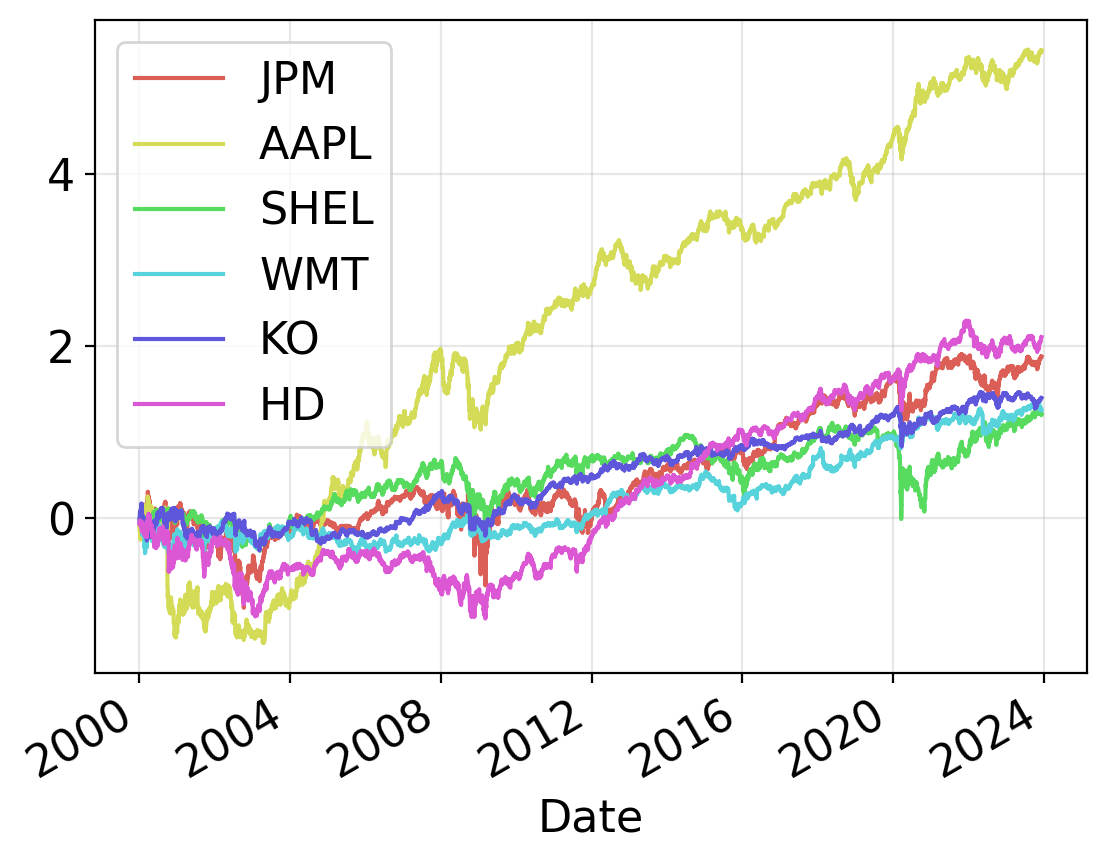

In [10]:
datasets_logr = pd.DataFrame(np.array(returns), index=datasets.index[1:], columns=assets)
index_date = datasets_logr.index
(datasets_logr.cumsum()).plot()
plt.grid(alpha=0.3)
plt.savefig("../figures/bandits-log-cumreturn.pdf")

# Stationary $\epsilon$-greedy bandit

In [11]:
import jfin

def store_reward(state, action, reward):
    return reward

def store_reward_action(state, action, reward):
    return reward, action

In [12]:
key = jax.random.PRNGKey(3141)
agent = jfin.EpsilonGreedyAgent(epsilon=0.5)
state_final, returns_bandit = agent.init_and_run(key, returns, store_reward)

In [13]:
sr_ann = returns_bandit.mean() / returns_bandit.std() * jnp.sqrt(252)
sr_ann

Array(0.68431437, dtype=float32)

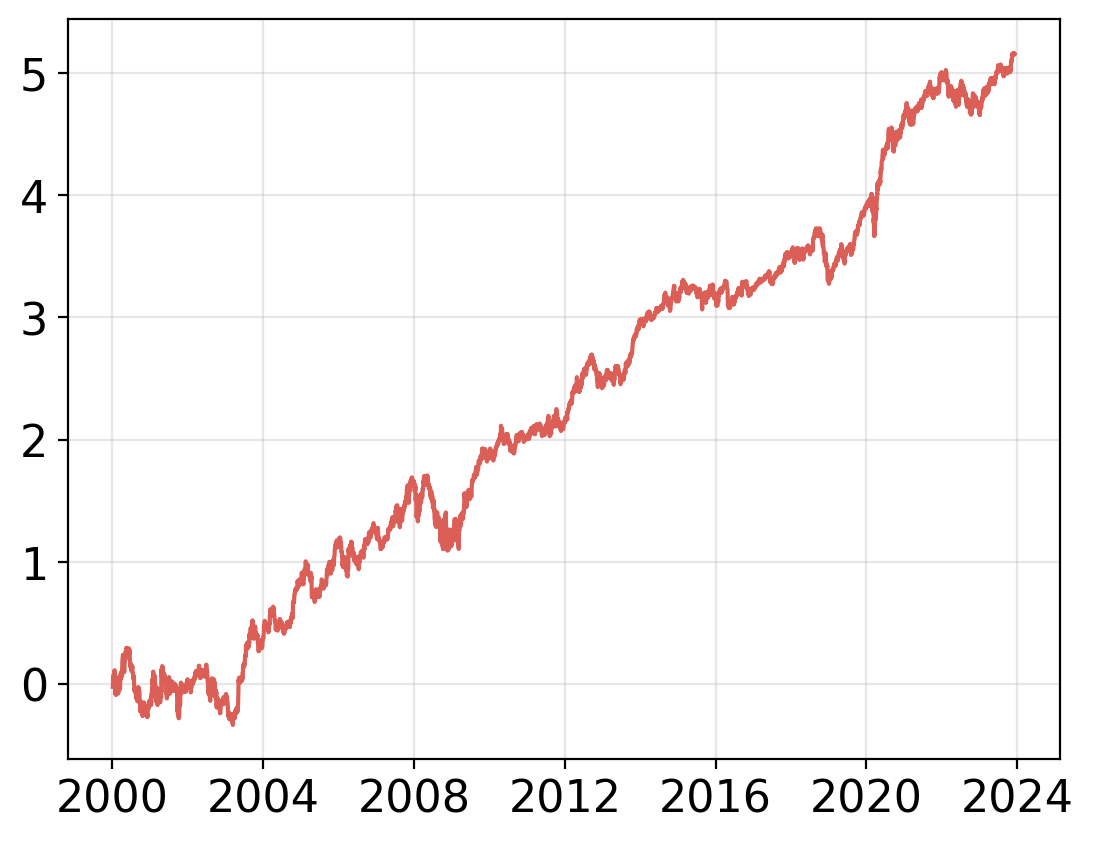

In [14]:
plt.plot(index_date, returns_bandit.cumsum())
plt.grid(alpha=0.3)

## Multiple simulations

Is this a winning strategy?

In [15]:
n_sims = 50
state_final, returns_bandit = agent.init_and_run_sims(key, returns, store_reward, n_sims)
returns_bandit.shape

(50, 6021)

In [16]:
sr_ann = returns_bandit.mean(axis=-1) / returns_bandit.std(axis=-1) * jnp.sqrt(252)
jnp.percentile(sr_ann, 50)

Array(0.2521358, dtype=float32)

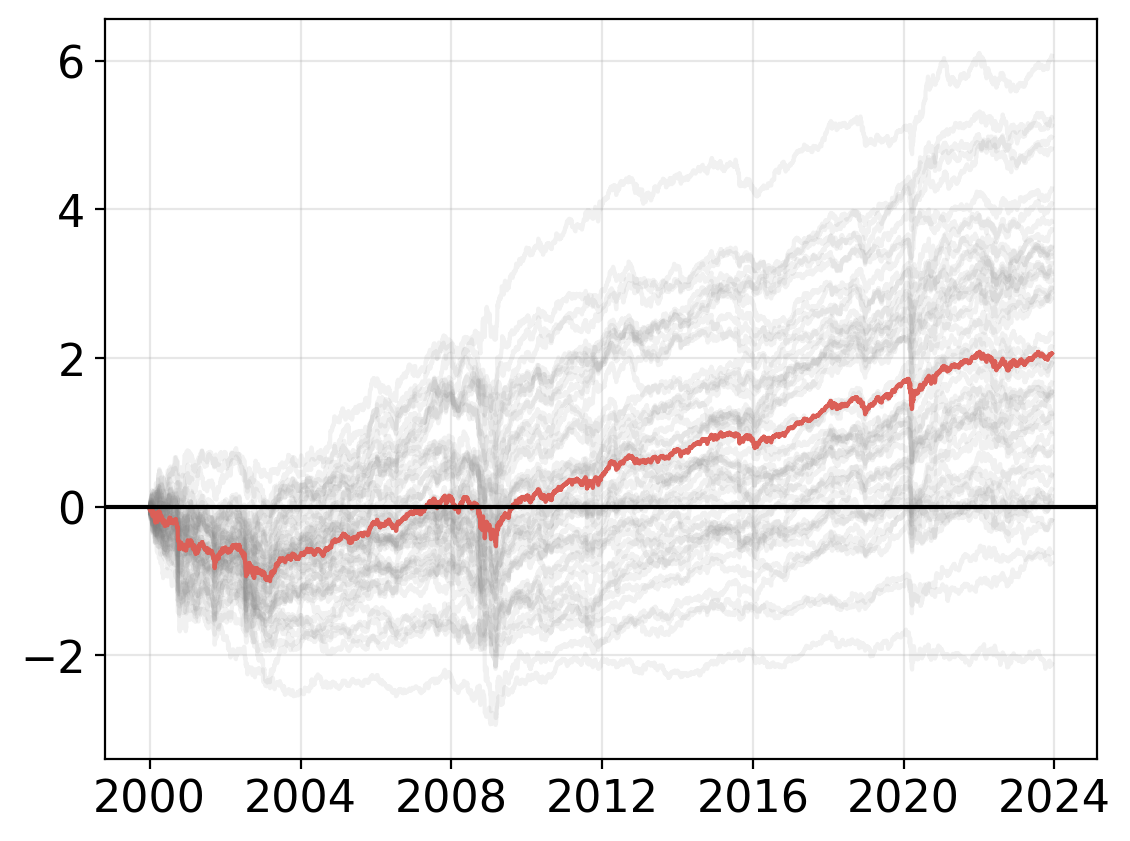

In [17]:
pnl_sims = np.array(returns_bandit.cumsum(axis=-1))
plt.plot(index_date, pnl_sims.T, alpha=0.1, c="tab:gray");
plt.plot(index_date, pnl_sims.mean(axis=0))
plt.axhline(y=0, c="black")
plt.grid(alpha=0.3)

## Evaluating over multiple $\epsilon$ values

In [18]:
@partial(jax.vmap, in_axes=(0, 0, None, None))
def eval_epsilon(key, epsilon, data, n_sims):
    agent = jfin.EpsilonGreedyAgent(epsilon=epsilon)
    state_final, returns = agent.init_and_run_sims(key, data, store_reward, n_sims)
    res = {
        "pnl": returns.sum(axis=-1),
        "sr_ann": returns.mean(axis=-1) / returns.std(axis=-1) * np.sqrt(252),
        "epsilon": epsilon
    }
    
    return res

In [19]:
%%time
n_sims = 100
n_epsilon_values = 25
epsilon_values = jnp.linspace(0.01, 1, n_epsilon_values)

keys_epsilon = jax.random.split(key, n_epsilon_values)
res = eval_epsilon(keys_epsilon, epsilon_values, returns, n_sims)
res = jax.tree_map(np.array, res)

CPU times: user 2.52 s, sys: 0 ns, total: 2.52 s
Wall time: 11.1 s


### Sharpe ratio

In [20]:
returns_sr = pd.DataFrame(res["sr_ann"], index=epsilon_values).T

returns_sr_mean = returns_sr.mean()
returns_sr_mean.name = "mean_sr"

palette = sns.color_palette("viridis_r", n_epsilon_values)

colors = returns_sr_mean.reset_index().sort_values("mean_sr", ascending=False)
colors.index = sorted(colors.index)
colors = colors.reset_index()

colors["hue"] = colors.apply(lambda row: palette[int(row["level_0"])], axis=1)
colors = colors.sort_values("index")["hue"].to_list()

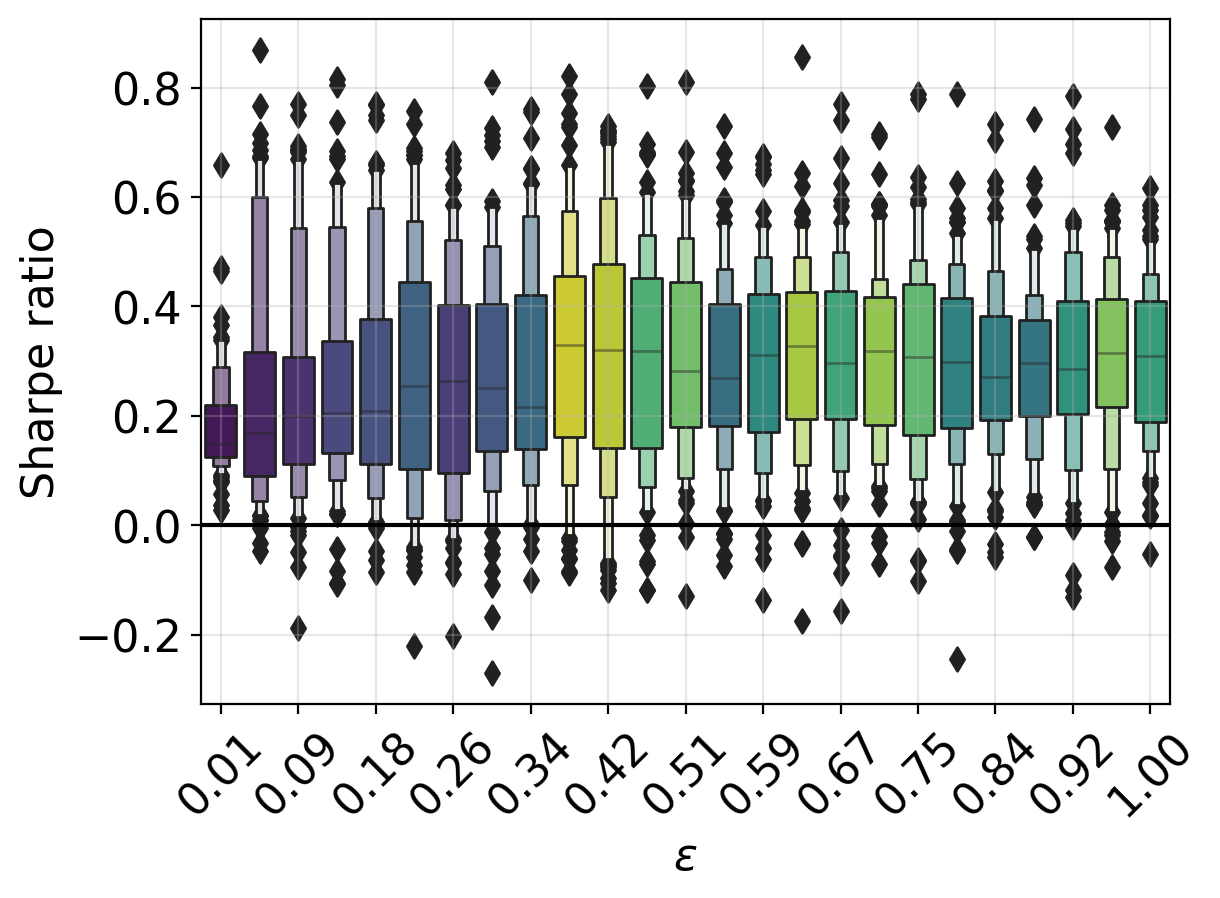

In [21]:
sns.boxenplot(
    x="variable",
    y="value",
    data=returns_sr.melt(),
    palette=colors,
    linewidth=1
)

plt.grid(alpha=0.3)
values, ticks = plt.xticks()
ticks = [format(float(t.get_text()), "0.2f") for t in ticks]
plt.xticks(values[::2], ticks[::2], rotation=45)
plt.xlabel("$\epsilon$")
plt.ylabel("Sharpe ratio")
plt.axhline(y=0, c="black")
plt.tight_layout()
plt.savefig("../figures/stationary-bandit-mean-sr.pdf")

### PnL

In [22]:
returns_pnl = pd.DataFrame(res["pnl"], index=epsilon_values).T

returns_pnl_mean = returns_pnl.mean()
returns_pnl_mean.name = "pnl"

palette = sns.color_palette("viridis_r", n_epsilon_values)

colors = returns_pnl_mean.reset_index().sort_values("pnl", ascending=False)
colors.index = sorted(colors.index)
colors = colors.reset_index()

colors["hue"] = colors.apply(lambda row: palette[int(row["level_0"])], axis=1)
colors = colors.sort_values("index")["hue"].to_list()

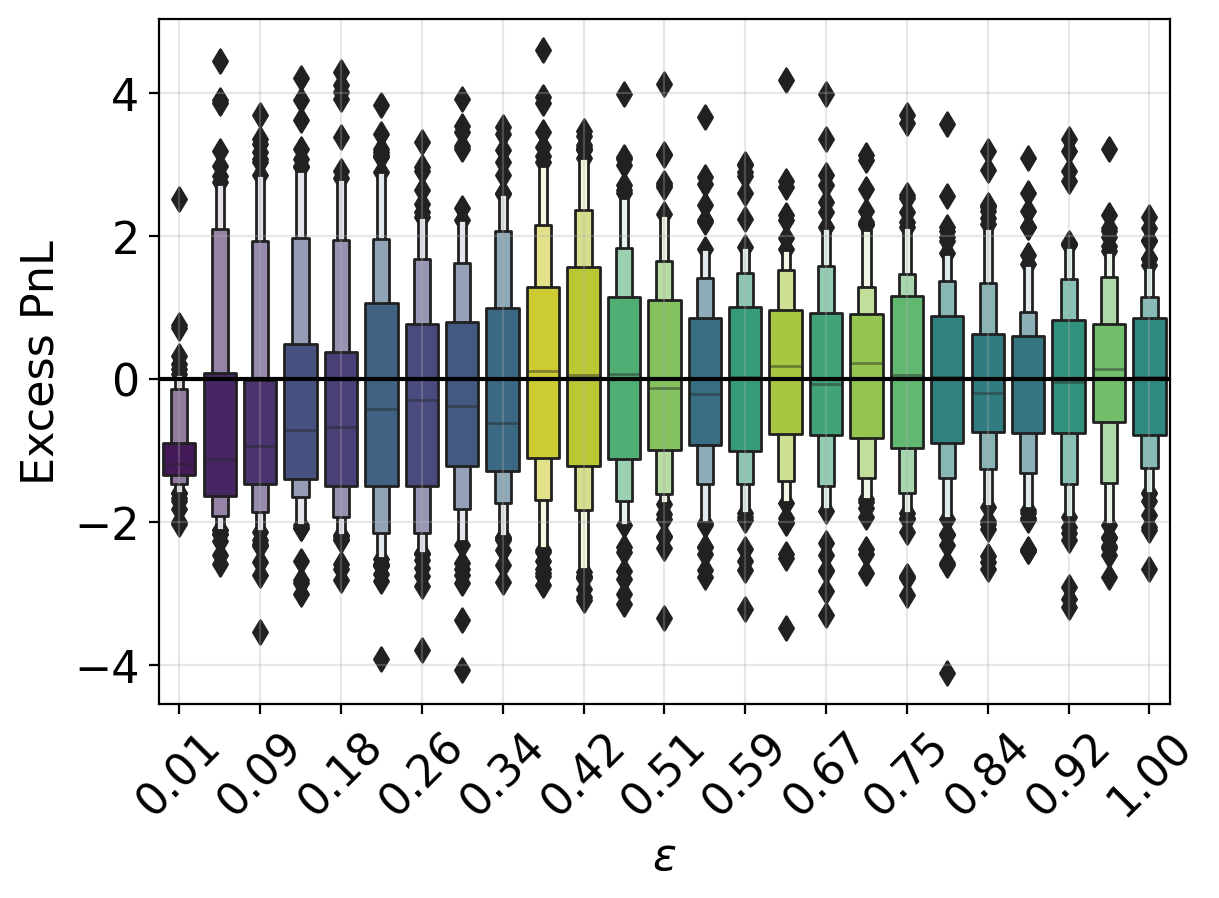

In [23]:
sns.boxenplot(
    x="variable",
    y="value",
    data=(returns_pnl - returns_pnl[1].mean()).melt(),
    palette=colors,
    linewidth=1
)

plt.grid(alpha=0.3)
values, ticks = plt.xticks()
ticks = [format(float(t.get_text()), "0.2f") for t in ticks]
plt.xticks(values[::2], ticks[::2], rotation=45)
plt.xlabel("$\epsilon$")
plt.ylabel("Excess PnL")
plt.axhline(y=0, c="black")
plt.tight_layout()
plt.savefig("../figures/stationary-bandit-mean-sr.pdf")

# non-stationary $\epsilon$-greedy

## Evaluating over multiple $\epsilon$ values

In [24]:
@partial(jax.jit, staticargnames=("n_sims",))
@partial(jax.vmap, in_axes=(None, None, 0, None, None))
@partial(jax.vmap, in_axes=(None, 0, None, None, None))
def eval_epsilon_alpha(key, epsilon, alpha, data, n_sims):
    agent = jfin.EpsilonGreedyAgent(epsilon=epsilon, alpha=alpha)
    state_final, returns = agent.init_and_run_sims(key, data, store_reward, n_sims)
    res = {
        "pnl": returns.sum(axis=-1),
        "sr_ann": returns.mean(axis=-1) / returns.std(axis=-1) * np.sqrt(252),
        "epsilon": epsilon,
        "alpha": alpha
    }
    
    return res

In [25]:
%%time
n_sims = 100
n_epsilon_values = 15
n_alpha_values = 20
epsilon_values = jnp.linspace(0.01, 1, n_epsilon_values)
alpha_values = jnp.linspace(0.01, 1, n_alpha_values)

keys_epsilon = jax.random.split(key, n_epsilon_values)
res = eval_epsilon_alpha(key, epsilon_values, alpha_values, returns, n_sims)
res = jax.tree_map(np.array, res)

CPU times: user 3.12 s, sys: 85.8 ms, total: 3.2 s
Wall time: 2min


In [26]:
sr_ann = pd.DataFrame(res["sr_ann"].mean(axis=-1), index=alpha_values, columns=epsilon_values)

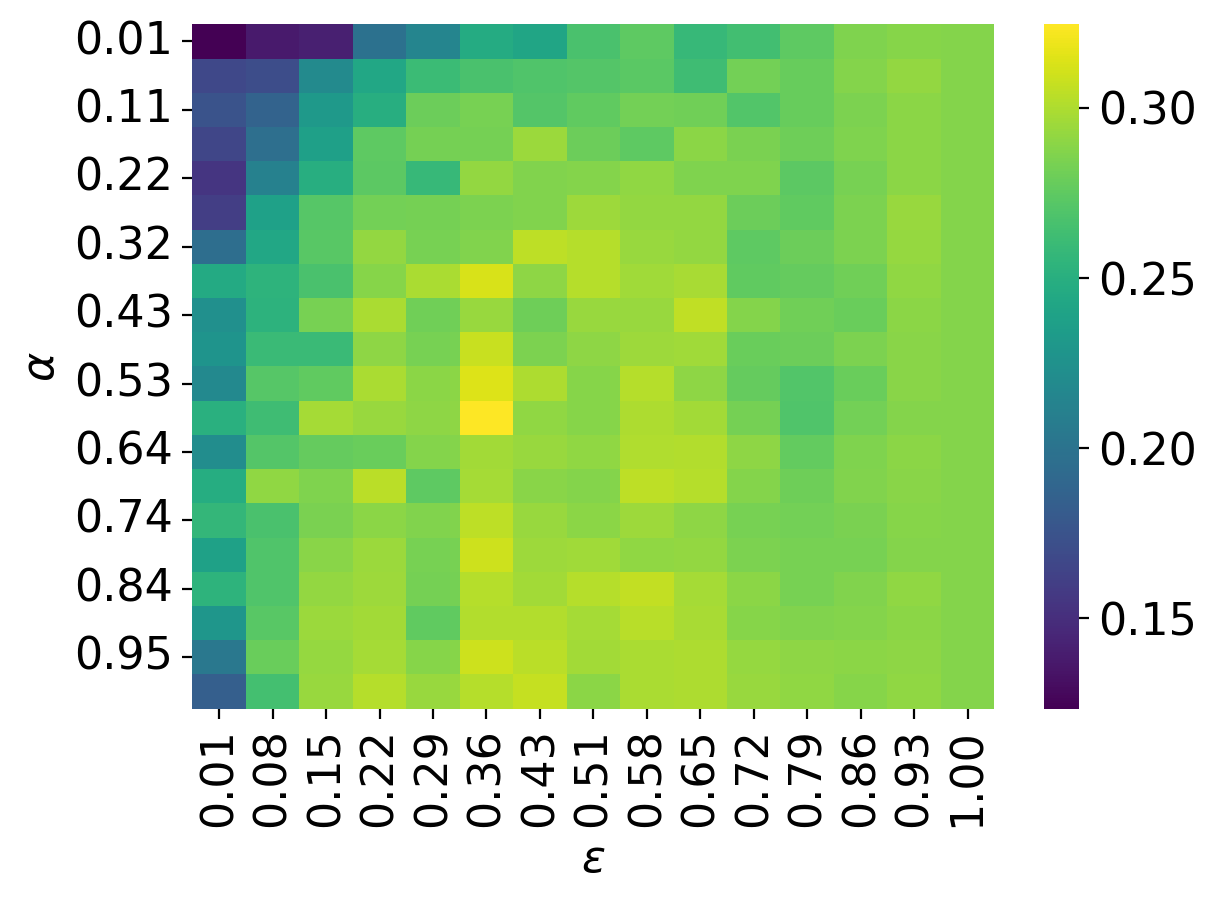

In [27]:
ax = sns.heatmap(sr_ann, cmap="viridis")
ax.invert_yaxis()

ax.set_yticklabels([format(float(v.get_text()), "0.2f") for v in ax.get_yticklabels()])
ax.set_xticklabels([format(float(v.get_text()), "0.2f") for v in ax.get_xticklabels()])
ax.invert_yaxis()

plt.xlabel(r"$\epsilon$")
plt.ylabel(r"$\alpha$")
plt.tight_layout()
# plt.savefig("../figures/non-stationary-alpha-epsilon-grid-sr.pdf", dpi=300);

### PnL

In [39]:
returns_pnl = pd.DataFrame(res["pnl"][-5], index=epsilon_values).T

returns_pnl_mean = returns_pnl.mean()
returns_pnl_mean.name = "pnl"

palette = sns.color_palette("viridis_r", n_epsilon_values)

colors = returns_pnl_mean.reset_index().sort_values("pnl", ascending=False)
colors.index = sorted(colors.index)
colors = colors.reset_index()

colors["hue"] = colors.apply(lambda row: palette[int(row["level_0"])], axis=1)
colors = colors.sort_values("index")["hue"].to_list()

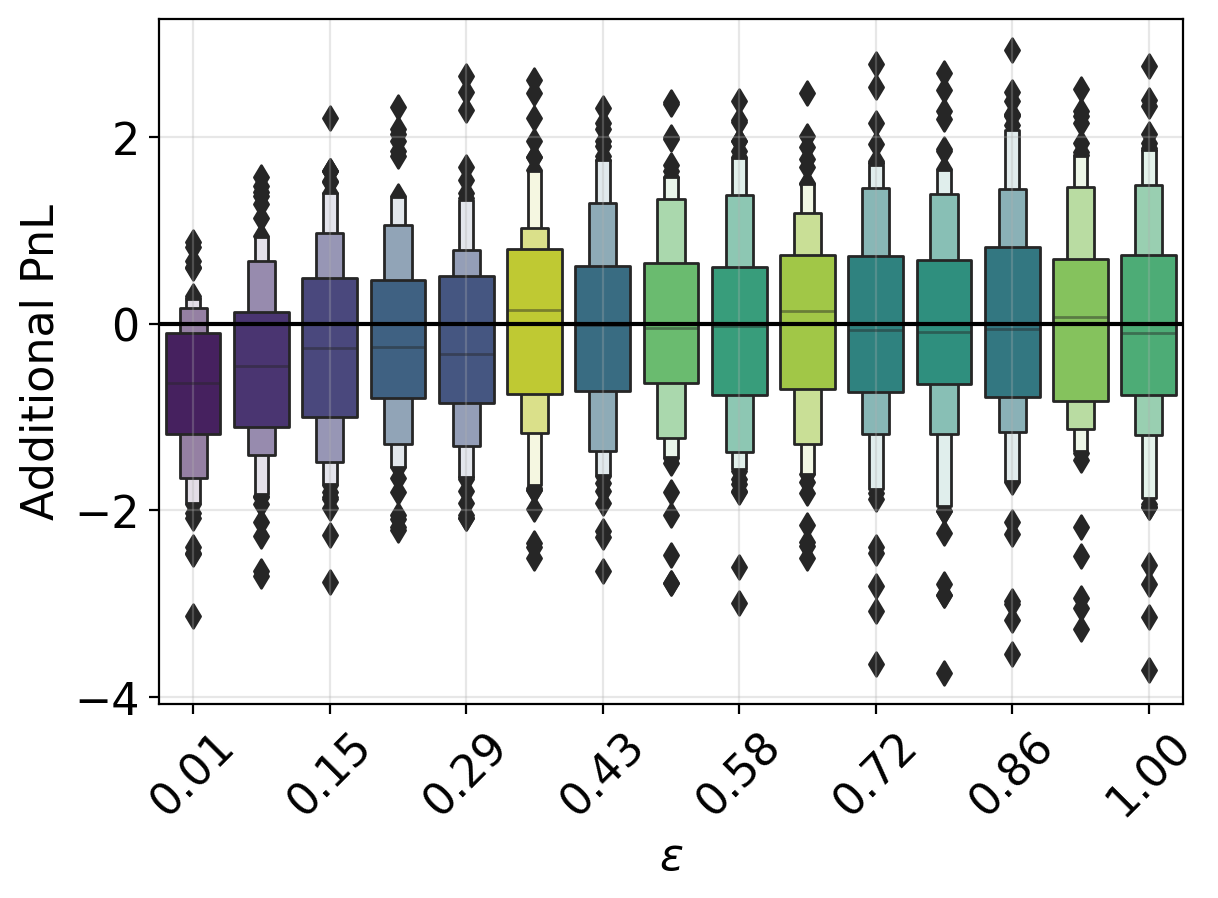

In [40]:
sns.boxenplot(
    x="variable",
    y="value",
    data=(returns_pnl - returns_pnl[1].mean()).melt(),
    palette=colors,
    linewidth=1
)

plt.grid(alpha=0.3)
values, ticks = plt.xticks()
ticks = [format(float(t.get_text()), "0.2f") for t in ticks]
plt.xticks(values[::2], ticks[::2], rotation=45)
plt.xlabel("$\epsilon$")
plt.ylabel("Additional PnL")
plt.axhline(y=0, c="black")
plt.tight_layout()
plt.savefig("../figures/non-stationary-bandit-mean-sr.pdf")

# Tabular Contextual bandits

In [41]:
context = (returns > 0) * 1
context.shape

(6021, 6)

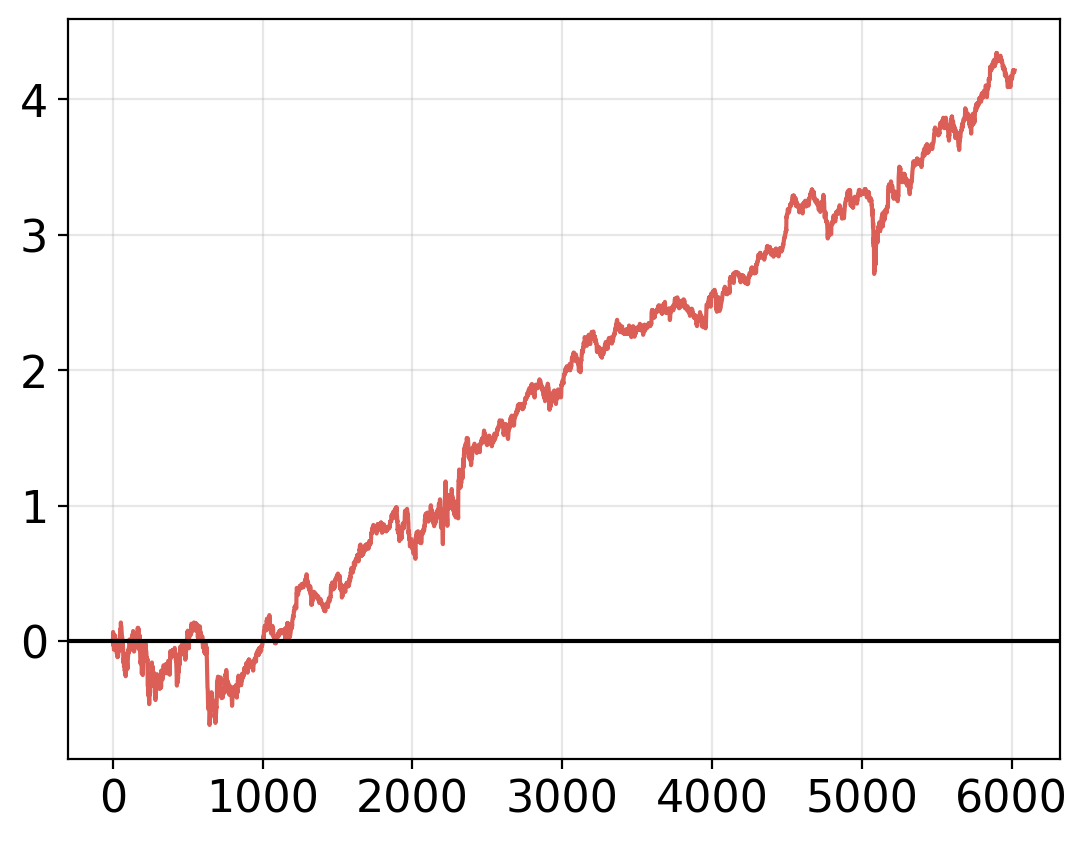

In [85]:
agent = jfin.TabularEpsilonGreedyAgent(epsilon=0.3, alpha=0.8)
agent

state, (rewards, actions) = agent.init_and_run(key, returns[1:], context[:-1], store_reward_action)

plt.plot(rewards.cumsum())
plt.grid(alpha=0.3)
plt.axhline(y=0, c="black")

In [78]:
rewards.mean() / rewards.std() * np.sqrt(252)

Array(0.5828696, dtype=float32)

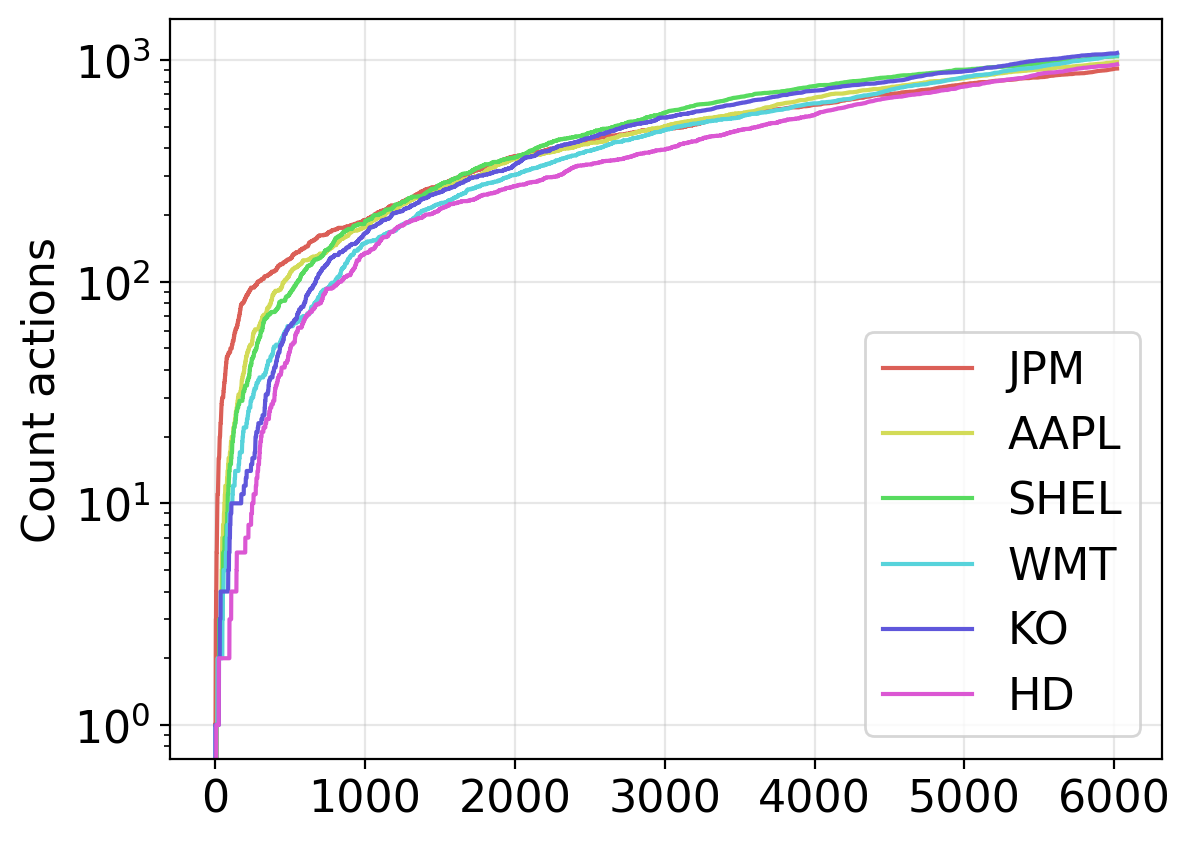

In [79]:
actions_ohe = jax.nn.one_hot(actions, len(assets))

plt.plot(actions_ohe.cumsum(axis=0), label=assets)
plt.legend()
plt.ylabel("Count actions")
plt.yscale("log")
plt.grid(alpha=0.3)

In [80]:
actions_ohe.sum(axis=0)

Array([ 916.,  981., 1040., 1049., 1077.,  957.], dtype=float32)

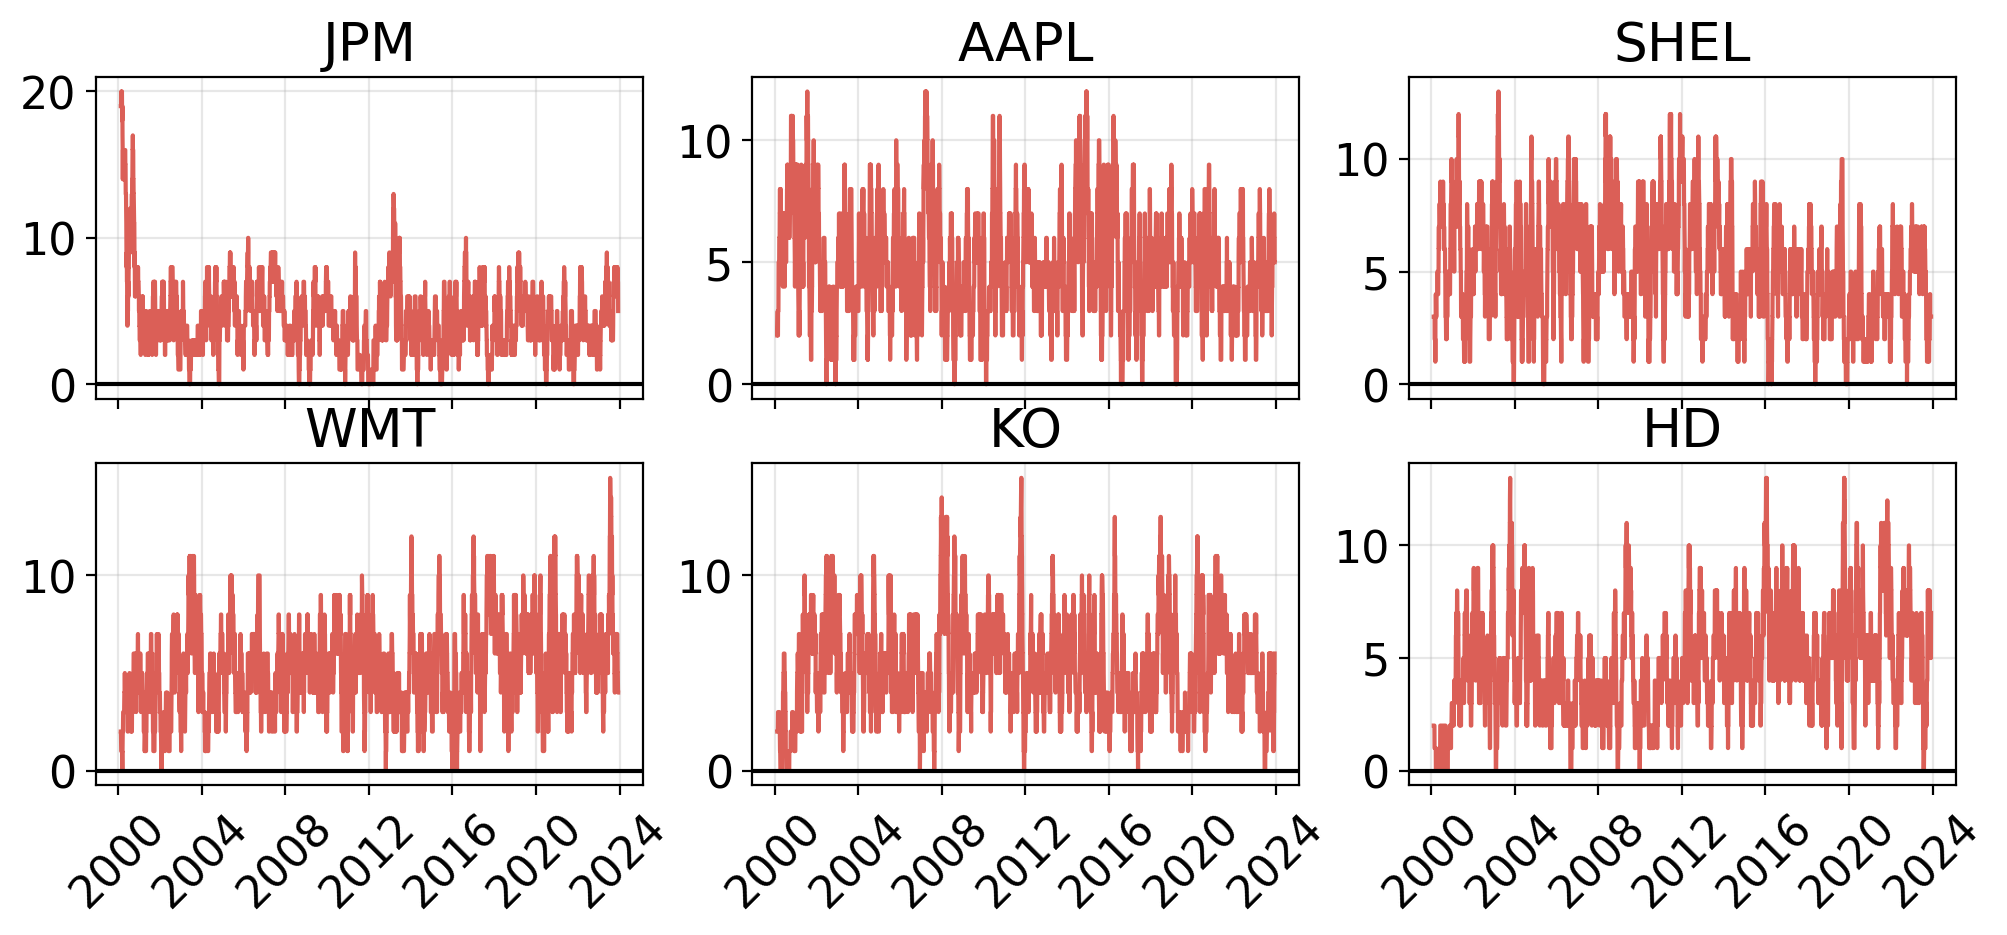

In [81]:
fig, ax = plt.subplots(2, 3, sharex=True, figsize=(12, 4.6))
ax = ax.ravel()
v = pd.DataFrame(actions_ohe, index=datasets.index[2:]).rolling(30).sum()
for i, axi in enumerate(ax):
    axi.set_title(assets[i])
    axi.plot(v[i])
    axi.axhline(y=0, c="black")
    axi.grid(alpha=0.3)
    plt.sca(axi)
    plt.xticks(rotation=45)